In [1]:
%%html
<style type='text/css'>
  .rendered_html {
      font-family: Courier New;
      font-size:110%;
      line-height:115%;
  }
  .rendered_html code {
      font-size: 90%;
  }
</style>

# Chapter 4 -- Recognizing Handwritten Digits

In this chapter we'll take a look under the hood to understand in detail what was going on during the training of the classifiers in previous chapters. 

We'll work through a simplified version of the handwritten digits recognition problem, starting with a very simple baseline model, and then use all of the machinery that deep learning models use to solve this and more sophisticated problems.

The most important concepts we'll see are:

+ Loss Functions
+ Function Optimization
+ Stochastic Gradient Descent
+ Gradient Computation
+ Tensor Broadcasting
+ Training Loops
+ Computational Graphs

## 4.1 Exploring Input Data

In [2]:
from fastai.vision.all import *

In [3]:
path = untar_data(URLs.MNIST_SAMPLE)

In [4]:
path.ls()

(#3) [Path('/root/.fastai/data/mnist_sample/train'),Path('/root/.fastai/data/mnist_sample/labels.csv'),Path('/root/.fastai/data/mnist_sample/valid')]

In [5]:
!head /root/.fastai/data/mnist_sample/labels.csv

name,label
train/3/7463.png,0
train/3/21102.png,0
train/3/31559.png,0
train/3/46882.png,0
train/3/26209.png,0
train/3/41391.png,0
train/3/11910.png,0
train/3/52435.png,0
train/3/21660.png,0


In [6]:
(path/'train').ls()

(#2) [Path('/root/.fastai/data/mnist_sample/train/7'),Path('/root/.fastai/data/mnist_sample/train/3')]

In [7]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('/root/.fastai/data/mnist_sample/train/3/10.png'),Path('/root/.fastai/data/mnist_sample/train/3/10000.png'),Path('/root/.fastai/data/mnist_sample/train/3/10011.png'),Path('/root/.fastai/data/mnist_sample/train/3/10031.png'),Path('/root/.fastai/data/mnist_sample/train/3/10034.png'),Path('/root/.fastai/data/mnist_sample/train/3/10042.png'),Path('/root/.fastai/data/mnist_sample/train/3/10052.png'),Path('/root/.fastai/data/mnist_sample/train/3/1007.png'),Path('/root/.fastai/data/mnist_sample/train/3/10074.png'),Path('/root/.fastai/data/mnist_sample/train/3/10091.png')...]

In [8]:
img3_path = threes[1]
img3 = Image.open(img3_path); img3

In [9]:
array(img3)[4:10, 4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

In [10]:
tensor(img3)[4:10, 4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

In [11]:
img3_tensor = tensor(img3)
df = pd.DataFrame(img3_tensor[4:15, 4:22])
df.style.set_properties(**{'font-size': '6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


## 4.2 Designing a Solution: 🤔 Stop and Think

Before we see some approaches to solve this problem, spend some time thinking how *you* would solve the problem if this was a novel problem (i.e., if no one had attempted to solve it before, so Googling for an answer wouldn't help)

**An Algorithmic Approach: Image as a Graph**

One possibility is to segment each image into two atomic kinds of shapes: straight lines (vertical, horizontal or slanted) and curved lines. After having identified all such parts, we can build a graph where vertices represent the parts and edges the junctions between them.

With such a representation, we can then use a "soft" graph isomorphism algorithm to find a similarity score between two graphs. This score would then serve to make a classification.

Some challenges with this scheme are:

+ **Nodes Relevance** If all nodes have the same relevance, strong noise in the image will end up affecting recognition performance. Therefore we need to weight vertices so as to give more importance to strokes that are more likely to be relevant for the identity of an object. Clearly, there is some learning involved in this, as it's very hard to code a priori which strokes matter most.


+ **Shape Recognition** How do we recognize lines and arcs? Hard-coding shape detectors is one possibility, but we need to be careful about their definition to make them flexible enough. This means being able to detect lines in all possible orientations. Special casing is likely to lead to a brittle program, though. Another concern is how to deal with lines of various widths. Lines of a single pixel may be easy enough, but what about lines several pixels wide?


+ **Graph Isomorphism** Even though graph isomorphism is a well-studied problem in mathematics (but a rather hard problem with no known general and efficient solution), in this instance we need something even more flexible that does pattern matching. This calls for additional research.

One possibility to deal with the issue of thick lines might be to have a base algorithm (one that works on one-pixel lines) on eroded versions of the image (so as to thin thick lines), and then superpose the results into a single image to be fed into the algorithm that builds the graph.

Something nice about this graph-based framework is that it can be used for more than the simple problem of handwritten digits recognition. For any problem where we can detect individual features, and those features have relationships among each other, this general algorithm can prove useful.

## 4.3 First Approach: Pixelwise Similarity
One approach to solve this problem is to build an "ideal" number for each category (an ideal 3 and an ideal 7) from the training data, and then during inference compute the "distance" to that ideal number.

The distance can be defined as the mean of the differences between individual pixels, and the ideal number for each category could be simply the average of the corresponding training samples.

In [12]:
seven_tensors = [tensor(Image.open(path)) for path in sevens]
three_tensors = [tensor(Image.open(path)) for path in threes]
len(three_tensors), len(seven_tensors)

(6131, 6265)

torch.Size([28, 28])

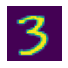

In [13]:
show_image(three_tensors[1])
seven_tensors[0].shape

In [14]:
# We divide by 255 to normalize (remember that pixels
# are in the range 0-255). Even though this is not
# absolutely necessary, it is a useful trick to help
# deep learning models learn faster.
stacked_7s = torch.stack(seven_tensors).float() / 255

# We also stack the images into a single tensor because
# models in PyTorch only take tensors as inputs.
stacked_3s = torch.stack(three_tensors).float() / 255
stacked_3s.shape, stacked_7s.shape

(torch.Size([6131, 28, 28]), torch.Size([6265, 28, 28]))

### "Ideal" 3 and 7

torch.Size([28, 28])

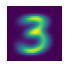

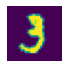

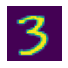

In [15]:
# Taking the mean on axis=0 means that:
#
# 1) the result will have the axis=0 removed;
# 2) each element in the result (in this case, each pixel) will be the mean
#    of all elements with the same coordinate (excluding the coordinate for
#    axis=0); i.e., result[i,j] = mean(stacked_3s[:,i,j])
ideal3 = stacked_3s.mean(axis=0)
show_image(ideal3), show_image(stacked_3s[0]), show_image(stacked_3s[1])
ideal3.shape

torch.Size([28, 28])

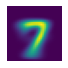

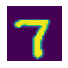

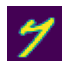

In [16]:
ideal7 = stacked_7s.mean(axis=0)
show_image(ideal7), show_image(stacked_7s[0]), show_image(stacked_7s[1])
ideal7.shape

### 🤔 Stop and Think

**How would you define similarity between tensors representing threes or sevens?**

One possibility is to "flatten" the images and consider them as one-dimensional vectors. This will discard spatial information, but maybe it will be good enough for our purposes.

Once they've been turned into vectors, we can use one of the well-known similarity measures between vectors (e.g., `F.cosine_similarity`)

In [17]:
stacked_3s.shape

torch.Size([6131, 28, 28])

In [18]:
stacked_3s.reshape(stacked_3s.shape[0], -1).shape

torch.Size([6131, 784])

tensor(0.8533)

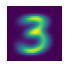

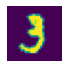

In [19]:
ideal3_vector = ideal3.reshape(-1)
some3_vector = stacked_3s[0].reshape(-1)

# We have to explicitly say dim=0 because by the default
# PyTorch assumes we're passing tensors where the first
# dimension indexes the samples
show_image(ideal3), show_image(stacked_3s[0])
F.cosine_similarity(ideal3_vector, some3_vector, dim=0)

tensor(0.5813)

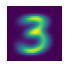

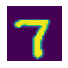

In [20]:
some7_vector = stacked_7s[0].reshape(-1)

# We have to explicitly say dim=0 because by the default
# PyTorch assumes we're computing on tensors where the
# first dimension indexes the batch of samples
show_image(ideal3), show_image(stacked_7s[0])
F.cosine_similarity(ideal3_vector, some7_vector, dim=0)

tensor(0.8362)

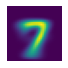

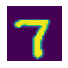

In [21]:
ideal7_vector = ideal7.reshape(-1)

show_image(ideal7), show_image(stacked_7s[0])
F.cosine_similarity(ideal7_vector, some7_vector, dim=0)

### Cosine Similarity Interpretation
Something to keep in mind is that the range of the cosine similarity function is `[-1, +1]`. The more similar two vectors are to each other, the values approach 1. The more dissimilar they are, the values approach -1.

In [22]:
stacked_3s.shape # => [6131, 28, 28] but we need [6131, 784]

torch.Size([6131, 28, 28])

In [23]:
# Comparing an ideal 3 to all 3s
stacked_3s_as_vectors = stacked_3s.reshape(stacked_3s.shape[0], -1)
similarities1_0 = F.cosine_similarity(
    # dim=-1 instructs PyTorch to use the vector in the last dimension
    # of the tensors to compute the similarity (keep in mind that the
    # first one indexes samples)
    stacked_3s_as_vectors, ideal3_vector, dim=-1)
similarities1_0.mean()

tensor(0.7257)

In [24]:
# Comparing an ideal 3 to all 7s
stacked_7s_as_vectors = stacked_7s.reshape(stacked_7s.shape[0], -1)
similarities2_0 = F.cosine_similarity(
    stacked_7s_as_vectors, ideal3_vector, dim=-1)
similarities2_0.mean()

tensor(0.5013)

The following figure illustrates how `F.cosine_similarity` handles a comparison between a tensors with multiple vectors (shape NxD) and a tensor with just a vector (shape D):

![Broadcasting Tensors](https://www.w3resource.com/w3r_images/python-numpy-exercise-124.svg)

The figure shows the concept of "broadcasting" with the `+` operator, but you can in fact use any other operator which works on scalars. We'll see this important concept in more detail later on.

### Other Similarity Measures
It is also possible to use other distance measures between vectors, but one thing to consider is normalization (although that's merely for interpretation; if ranking or pairwise comparison is all we need, then absolute distance is just fine).

For example, PyTorch defines the `pairwise_distance` function, which works as follows:

In [25]:
# comparing an ideal 3 to all 3s (alternative)
similarities2_0 = F.pairwise_distance(
    stacked_7s.reshape(stacked_7s.shape[0], -1), ideal3_vector)
similarities2_0.mean()

tensor(8.0184)

In [26]:
# comparing an ideal 3 to all 7s (alternative)
similarities1_1 = F.pairwise_distance(
    stacked_3s.reshape(stacked_3s.shape[0], -1), ideal3_vector)
similarities1_1.mean()

tensor(6.6454)

<AxesSubplot:>

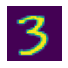

In [27]:
some3 = stacked_3s[1]
show_image(some3)

## 4.4 Model Evaluation: Loss Functions

Although we could definitely use some of the distance functions we saw above to construct a loss function for our problem, we can also find similarity between images in their original form by looking at differences between individual pixels and then averaging the results across each image:

In [28]:
# (some3 - ideal3) is an element-wise operation between tensors
distance_3_abs = (some3 - ideal3).abs().mean()
# rmse: root mean squared error
distance_3_rmse = ((some3 - ideal3)**2).mean().sqrt()
distance_3_abs, distance_3_rmse

(tensor(0.1114), tensor(0.2021))

In [29]:
distance_7_abs = (some3 - ideal7).abs().mean()
# rmse: root mean squared error
distance_7_rmse = ((some3 - ideal7)**2).mean().sqrt()
distance_7_abs, distance_7_rmse

(tensor(0.1586), tensor(0.3021))

PyTorch (accessible in `fastai` in the `F` namespace) has functions for both of these cost functions:

In [30]:
F.l1_loss(some3, ideal7), F.mse_loss(some3, ideal7).sqrt()

(tensor(0.1586), tensor(0.3021))

`l1` stands for "L1 norm". Roughly speaking, a norm represents the "size" of a vector. You can read more about it [here](https://machinelearningmastery.com/vector-norms-machine-learning/#:~:text=The%20length%20of%20the%20vector,vector's%20magnitude%20or%20the%20norm)

### Validation Set
For the purposes of evaluating a model, it is crucial to have a validation set that we didn't use during training:

In [31]:
threes_path = path/'valid'/'3'
validation_3s = torch.stack([tensor(Image.open(path)) for path in threes_path.ls()])
validation_3s = validation_3s.float() / 255

In [32]:
sevens_path = path/'valid'/'7'
validation_7s = torch.stack([tensor(Image.open(path)) for path in sevens_path.ls()])
validation_7s = validation_7s.float() / 255

In [33]:
validation_3s.shape, validation_7s.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

### Pixelwise Loss Function
The following function will capture the amount of error (distance) between ideal numbers and the samples we want to classify:

In [34]:
def mnist_distance(ideal, sample):
    # a.shape === b.shape (virtually at least, because of broadcasting)
    # (-1, -2) means to perform the mean across the last and the second-to-last axes
    return (ideal-sample).abs().mean((-1, -2))

In [35]:
mnist_distance(ideal3, some3)

tensor(0.1114)

In [36]:
# This will compute the absolute differences between corresponding pixels in the 
# validation 3s and  the "ideal" 3. The results for each image will then be averaged,
# resulting in a vector of "distances"
distance_validation_3s = mnist_distance(ideal3, validation_3s)
distance_validation_3s, distance_validation_3s.shape

(tensor([0.1328, 0.1523, 0.1245,  ..., 0.1383, 0.1280, 0.1138]),
 torch.Size([1010]))

### Broadcasting

If you've been paying attention, you may be wondering how it is possible that despite the fact that `validation_3s` and `ideal3` have different shapes:

In [37]:
validation_3s.shape, ideal3.shape

(torch.Size([1010, 28, 28]), torch.Size([28, 28]))

`mnist_distance` was able to perform the subtraction between `ideal` and `sample` correctly. The reason for this is that PyTorch does "broadcasting". Roughly speaking:

> Broadcasting is an operation of matching the dimensions of differently shaped arrays in order to be able to perform further operations on those arrays (e.g., per-element arithmetic).

See the following resources to get a better grasp of how broadcasting works:

+ [How Broadcasting Works](https://stackoverflow.com/questions/51371070/how-does-pytorch-broadcasting-work)
+ [Broadcasting in Numpy](https://towardsdatascience.com/broadcasting-in-numpy-58856f926d73)

In [38]:
def is_3(x):
    return mnist_distance(x, ideal3) < mnist_distance(x, ideal7)

In [39]:
is_3(some3), is_3(some3).float()

(tensor(True), tensor(1.))

<AxesSubplot:>

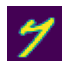

In [40]:
some7 = stacked_7s[1]
show_image(some7)

In [41]:
is_3(some7), is_3(some7).float()

(tensor(False), tensor(0.))

In [42]:
validation_3s.shape

torch.Size([1010, 28, 28])

In [43]:
# Broadcasting at play once again!
is_3(validation_3s).float()

tensor([1., 1., 1.,  ..., 0., 1., 1.])

In [44]:
accuracy_3s = is_3(validation_3s).float().mean()
accuracy_7s = (1 - is_3(validation_7s).float()).mean()

print(f'3s accuracy: {round(accuracy_3s.item(), 3)}')
print(f'7s accuracy: {round(accuracy_7s.item(), 3)}')
print(f'average accuracy: {round((accuracy_3s + accuracy_7s).item() / 2.0, 3)}')

3s accuracy: 0.917
7s accuracy: 0.985
average accuracy: 0.951


Now let's see how this accuracy compares to the one we get by changing the distance metric. `mnist_distance2` transforms an image into a flat vector and compares two images so represented using cosine similarity:

In [45]:
def mnist_distance2(ideal, sample):
    # Semantically, ideal and sample are images (or collections of images)
    # a.shape === (N, W, H) where N === samples, W === image width, H  === image height
    ideal = torch.flatten(ideal, start_dim=-2)
    sample = torch.flatten(sample, start_dim=-2)
    return 1.0 - F.cosine_similarity(ideal, sample, dim=-1)

In [46]:
mnist_distance2(some3, ideal7)

tensor(0.4759)

In [47]:
def is_3(x):
    return mnist_distance2(x, ideal3) < mnist_distance2(x, ideal7)

In [48]:
accuracy_3s = is_3(validation_3s).float().mean()
accuracy_7s = (1 - is_3(validation_7s).float()).mean()

print(f'3s accuracy: {round(accuracy_3s.item(), 3)}')
print(f'7s accuracy: {round(accuracy_7s.item(), 3)}')
print(f'average accuracy: {round((accuracy_3s + accuracy_7s).item() / 2.0, 3)}')

3s accuracy: 0.968
7s accuracy: 0.958
average accuracy: 0.963


Interestingly, the average accuracy increases by a little over 1%, mostly thanks to the increase in accuracy for 3s and despite the decrease in accuracy for 7s

## 4.4 SGD: Stochastic Gradient Descent
**Key Concepts**
+ Loss (Cost) Function
+ Learning Rate
+ Model Parameters

SGD is an algorithm used to find the optimal weights in a neural network, i.e., the weights that will turn the neural network into a function approximator for the task we're interested in.

### 1-dimensional SGD
If our problem only had a single variable, the loss function might look as an inverted parabola, and finding the best possible network would amount to finding the minimum of this function, as illustrated in the following figure:

![](https://miro.medium.com/max/1400/1*GTRi-Y2doXbbrc4lGJYH-w.png)

### 2-dimensional SGD
The following pictures illustrates the same concept when using 2 variables. Notice that because we're not using only a subset (in the extreme a single training example at a time), our "descent" to the optimum may be irregular:

|![](https://www.researchgate.net/profile/Xudong-Huang-4/publication/328106221/figure/fig3/AS:678422925807621@1538760038610/Stochastic-gradient-descent-compared-with-gradient-descent.png)|
|:--:|
|*Contours view of the loss surface for 2D function*|

|![GD in 2D](https://metamug.com/article/images/gradient-descent.png)|
|:--:|
|*Surface of a 2-dimensional loss function*|

### SGD for Computational Graphs
More generally, SGD can be used to find the optimal weights for any computational graph that ends with a loss function. A neural network is an instance of a computational graph. We'll see what a computational graph looks like in a moment.

PyTorch has built-in support for automatic differentiation of the elements in the neural network (and in general for any computational graph). For example, for the following expression:

```python
x = torch.tensor(1)
y = torch.tensor(2)
v = x * y
w = torch.log(v)
z = w
```

The following figure illustrates both its forward and backward computational graph:

|![Computional Graph PyTorch](https://pytorch.org/assets/images/computational_graph_reverse_auto_differentiation.png)|
|:--:|
|*Computational graph of `z=log(x.y)`*|

This works with scalars (tensors of 0 dimension)...

$$ 
f(x) = x^2 
$$

$$
\frac{\partial f}{\partial x} = 2x
$$

### Automatic Differentiation (Automated Chain Rule)
In the previous computational graph, we saw both how the predictions (blue path), and the gradients to update the weights (green path) are computed.

In PyTorch, it is usually only needed to specify the former as the latter is automatically inferred, as long as the functions we specify are common. For functions unknown to PyTorch, it is necessary to provide both the forward and backward functions to fit into this framework.

In [49]:
def f(x):
    return x**2

xt = tensor(3.0).requires_grad_()
yt = f(xt); yt

tensor(9., grad_fn=<PowBackward0>)

In [50]:
xt.requires_grad

True

In [51]:
# compute gradients for all tensors with `requires_grad=True`
yt.backward()

In [52]:
xt.grad

tensor(6.)

...but it also works with tensors of arbitrary shape:

In [53]:
xt = tensor([3.0, 4.0, 10.0], requires_grad=True)

In [54]:
xt.requires_grad

True

|![Computational Graph PyTorch](https://user-images.githubusercontent.com/442314/179265235-29dc51fe-2d8d-41f1-893f-582509c73f2a.png)|
|:--:|
|*Computational graph of `y=sum(exp(x))`*|

In [55]:
def f(x):
    return (x**2).sum()

yt = f(xt)
yt

tensor(125., grad_fn=<SumBackward0>)

In [56]:
yt.backward()
xt.grad

tensor([ 6.,  8., 20.])

### End-to-End SGD Example

In [57]:
time = torch.arange(0, 20).float(); time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19.])

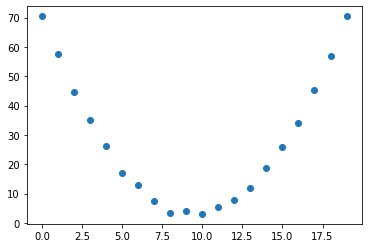

In [58]:
speed = torch.rand(20) * 3 + 0.75 * (time-9.5)**2 + 1
plt.scatter(time, speed)

$$
\Large f(t) = at^2 + bt + c
$$

In [59]:
def f(t, params):
    a, b, c = params
    return a*(t**2) + (b*t) + c

In [60]:
def mse(predictions, targets):
    return ((predictions-targets)**2).mean().sqrt()

In [61]:
params = torch.randn(3).requires_grad_()

In [62]:
predictions = f(time, params)

In [63]:
def show_predictions(predictions, ax=None):
    if ax is None:
        ax = plt.subplots()[1]
    ax.scatter(time, speed)
    # to_np is necessary because matplotlib only understands
    # numpy arrays but `predictions` are PyTorch tensors
    ax.scatter(time, to_np(predictions))
    ax.set_ylim(-300, 100)

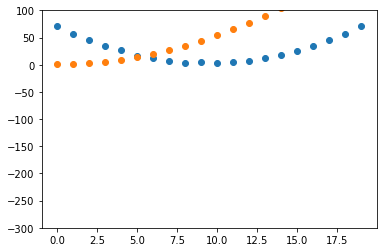

In [64]:
show_predictions(predictions)

In [65]:
loss = mse(predictions, speed); loss

tensor(69.2391, grad_fn=<SqrtBackward>)

In [66]:
# compute gradients
loss.backward()
params.grad

tensor([155.7534,   9.9962,   0.5482])

In [67]:
params

tensor([0.5162, 0.1623, 0.5671], requires_grad=True)

In [68]:
learning_rate = 1e-3
params.data -= learning_rate * params.grad.data
params.grad = None

In [69]:
predictions = f(time, params)
mse(predictions, speed)

tensor(45.9234, grad_fn=<SqrtBackward>)

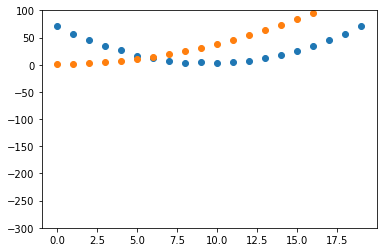

In [70]:
show_predictions(predictions)

In [71]:
def apply_step(params, show=True):
    predictions = f(time, params)
    loss = mse(predictions, speed)
    loss.backward()
    params.data -= learning_rate * params.grad.data
    params.grad = None
    if show:
        print(loss.item())
    return predictions

In [72]:
for _ in range(10):
    apply_step(params)

45.92341232299805
29.57659912109375
25.70260238647461
25.694149017333984
25.693931579589844
25.69379425048828
25.693660736083984
25.693525314331055
25.693391799926758
25.693256378173828


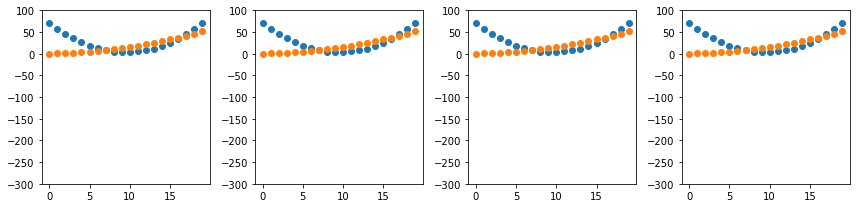

In [73]:
_, axes = plt.subplots(1, 4, figsize=(12, 3))
for axis in axes:
    show_predictions(apply_step(params, show=False), axis)
plt.tight_layout()

## MNIST Loss Function

### Preparing Validation Data

In [74]:
train_x = torch.cat([stacked_3s, stacked_7s]).view(-1, 28*28)
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
train_x.shape, train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

In [75]:
dataset = list(zip(train_x, train_y))
x, y = dataset[0]
x.shape, y

(torch.Size([784]), tensor([1]))

In [76]:
validation_x = torch.cat([validation_3s, validation_7s]).view(-1, 28*28)
validation_y = tensor([1]*len(validation_3s) + [0]*len(validation_7s)).unsqueeze(1)
validation_x.shape, validation_y.shape

(torch.Size([2038, 784]), torch.Size([2038, 1]))

In [77]:
validation_dataset = list(zip(validation_x, validation_y))

### Basic Building Block: Linear Layer

In [78]:
def init_params(size, stddev=1.0):
    return (torch.randn(size)*stddev).requires_grad_()

In [79]:
weights = init_params((28*28, 1))
bias = init_params(1)

In [80]:
(train_x[0]*weights.T).sum() + bias

tensor([-9.1521], grad_fn=<AddBackward0>)

In [81]:
def linear1(x_batch):
    return x_batch @ weights + bias

In [82]:
predictions = linear1(train_x); predictions

tensor([[ -9.1521],
        [-19.5438],
        [-11.1208],
        ...,
        [  4.8764],
        [ -1.8298],
        [ -5.2019]], grad_fn=<AddBackward0>)

In [83]:
corrects = (predictions > 0.0).float() == train_y
corrects

tensor([[False],
        [False],
        [False],
        ...,
        [False],
        [ True],
        [ True]])

In [84]:
corrects.float().mean().item()

0.41965150833129883

In [85]:
targets = tensor([1, 0, 1])
predictions = tensor([0.9, 0.4, 0.2])

### Loss Function -- V1

In [86]:
def mnist_loss(predictions, targets):
    return torch.where(targets==1, 1-predictions, predictions).mean()

In [87]:
torch.where(targets==1, 1-predictions, predictions)

tensor([0.1000, 0.4000, 0.8000])

In [88]:
mnist_loss(predictions, targets)

tensor(0.4333)

In [89]:
mnist_loss(tensor([0.9, 0.4, 0.8]), targets)

tensor(0.2333)

In [90]:
def sigmoid(x):
    return 1/(1 + torch.exp(-x))

/opt/conda/envs/fastai/lib/python3.8/site-packages/fastbook/__init__.py:74: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  /pytorch/aten/src/ATen/native/RangeFactories.cpp:25.)
  x = torch.linspace(min,max)


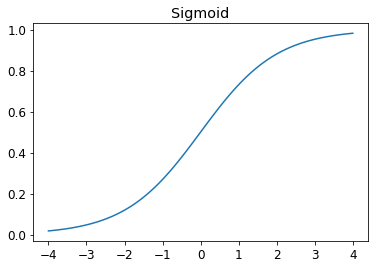

In [91]:
from fastbook import plot_function

plot_function(torch.sigmoid, title='Sigmoid', min=-4, max=4)

### Loss Function -- V2

In [92]:
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

In [93]:
dataloader = DataLoader(range(15), batch_size=5, shuffle=True)
list(dataloader)

[tensor([ 3, 12,  8, 10,  2]),
 tensor([ 9,  4,  7, 14,  5]),
 tensor([ 1, 13,  0,  6, 11])]

In [94]:
dataset1 = L(enumerate(string.ascii_lowercase))
dataset1

(#26) [(0, 'a'),(1, 'b'),(2, 'c'),(3, 'd'),(4, 'e'),(5, 'f'),(6, 'g'),(7, 'h'),(8, 'i'),(9, 'j')...]

In [95]:
dataloader = DataLoader(dataset1, batch_size=6, shuffle=True)
list(dataloader)

[(tensor([17, 18, 10, 22,  8, 14]), ('r', 's', 'k', 'w', 'i', 'o')),
 (tensor([20, 15,  9, 13, 21, 12]), ('u', 'p', 'j', 'n', 'v', 'm')),
 (tensor([ 7, 25,  6,  5, 11, 23]), ('h', 'z', 'g', 'f', 'l', 'x')),
 (tensor([ 1,  3,  0, 24, 19, 16]), ('b', 'd', 'a', 'y', 't', 'q')),
 (tensor([2, 4]), ('c', 'e'))]

In [96]:
# in this very simple model, we have a single output neuron
# if we had K output neurons, the shape of `weights` would
# be (28*28, K)
weights = init_params((28*28, 1))
bias = init_params(1)

In [97]:
dataloader = DataLoader(dataset, batch_size=256)
xb, yb = first(dataloader)
xb.shape, yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [98]:
validation_dataloader = DataLoader(validation_dataset, batch_size=256)

In [99]:
batch = train_x[:5]
batch.shape

torch.Size([5, 784])

In [100]:
predictions = linear1(batch)
predictions

tensor([[-2.8015],
        [-2.9294],
        [ 1.3709],
        [-1.8300],
        [-6.1362]], grad_fn=<AddBackward0>)

In [101]:
loss = mnist_loss(predictions, train_y[:5])
loss

tensor(0.7908, grad_fn=<MeanBackward0>)

In [102]:
loss.backward()
weights.grad.shape, weights.grad.mean(), bias.grad

(torch.Size([784, 1]), tensor(-0.0118), tensor([-0.0770]))

## The Training Loop

In [103]:
def compute_gradients(x_batch, y_batch, model):
    predictions = model(x_batch)
    loss = mnist_loss(predictions, y_batch)
    loss.backward()

In [104]:
compute_gradients(batch, train_y[:5], linear1)
weights.grad.mean(), bias.grad

(tensor(-0.0236), tensor([-0.1540]))

Notice that if we call the above cell twice, the gradients will change!

In [105]:
compute_gradients(batch, train_y[:5], linear1)
weights.grad.mean(), bias.grad

(tensor(-0.0354), tensor([-0.2309]))

In [106]:
weights.grad.zero_()
bias.grad.zero_()

tensor([0.])

In [107]:
def train_epoch(model, params, learning_rate):
    for x_batch, y_batch in dataloader:
        compute_gradients(x_batch, y_batch, model)
        for param in params:
            param.data -= learning_rate * param.grad
            param.grad.zero_()

In [108]:
def batch_accuracy(x_batch, y_batch):
    predictions = x_batch.sigmoid()
    correct = (predictions > 0.5) == y_batch
    return correct.float().mean()

In [109]:
batch_accuracy(linear1(batch), train_y[:5])

tensor(0.2000)

In [110]:
def validate_epoch(model):
    accuracies = [batch_accuracy(model(xb), yb) for xb, yb in validation_dataloader]
    return round(torch.stack(accuracies).mean().item(), 4)

In [111]:
validate_epoch(linear1)

0.3031

In [112]:
learning_rate = 1.
params = weights, bias
train_epoch(linear1, params, learning_rate)
validate_epoch(linear1)

0.4961

In [113]:
for i in range(20):
    train_epoch(linear1, params, learning_rate)
    print(validate_epoch(linear1), end=' ')

0.4991 0.5719 0.6005 0.8525 0.9233 0.9414 0.9472 0.9531 0.9575 0.9609 0.9619 0.9653 0.9668 0.9702 0.9726 0.9726 0.9741 0.9746 0.9751 0.9755 

### Basic Optimizer

In [114]:
class BasicOptimizer:
    def __init__(self, params, learning_rate):
        # creating a copy of the parameters is actually quite important!
        # if you don't do it, the updates in self.step() won't have any
        # effect (I guess this is by design -- we'll have to ask the fastai authors)
        self.params = list(params)
        self.learning_rate = learning_rate
    
    def step(self, *args, **kwargs):
        for param in self.params:
            param.data -= param.grad.data * self.learning_rate

    def zero_grad(self, *args, **kwargs):
        for param in self.params:
            param.grad = None

In [115]:
linear_model = nn.Linear(28*28, 1)

In [116]:
w, b = linear_model.parameters()
w.shape, b.shape

(torch.Size([1, 784]), torch.Size([1]))

In [117]:
def train_epoch(model, optimizer):
    for x_batch, y_batch in dataloader:
        compute_gradients(x_batch, y_batch, model)
        optimizer.step()
        optimizer.zero_grad()

In [118]:
def train_model(model, optimizer, epochs=10):
    for i in range(epochs):
        train_epoch(model, optimizer)
        print(validate_epoch(model), end=' ')

In [119]:
optimizer = BasicOptimizer(linear_model.parameters(), learning_rate)

In [120]:
learning_rate = 1e-2
train_model(linear_model, optimizer, epochs=20)

0.4932 0.7934 0.8476 0.9165 0.9345 0.9482 0.956 0.9633 0.9657 0.9672 0.9702 0.9716 0.9731 0.975 0.9755 0.9765 0.9775 0.978 0.9785 0.9785 

### Training the Model

In [121]:
linear_model = nn.Linear(28*28, 1)
optimizer = SGD(linear_model.parameters(), learning_rate)
train_model(linear_model, optimizer, epochs=20)

0.9096 0.9223 0.9447 0.9545 0.9613 0.9613 0.9617 0.9617 0.9632 0.9627 0.9637 0.9637 0.9647 0.9656 0.9656 0.9661 0.9666 0.9666 0.9671 0.9671 

In [122]:
dataloaders = DataLoaders(dataloader, validation_dataloader)

In [123]:
model = nn.Linear(28*28, 1)
learner = Learner(dataloaders, model, opt_func=SGD, loss_func=mnist_loss, metrics=batch_accuracy)

In [124]:
learner.fit(10, lr=learning_rate)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.461049,0.367614,0.947498,00:00
1,0.341307,0.274737,0.927870,00:00
2,0.259165,0.213508,0.946516,00:00
3,0.205770,0.174045,0.955348,00:00
4,0.170532,0.148876,0.959274,00:00
5,0.146770,0.131907,0.960746,00:00
6,0.130204,0.119760,0.960746,00:00
7,0.118187,0.110626,0.962709,00:00
8,0.109114,0.103486,0.962218,00:00
9,0.102014,0.097733,0.962709,00:00


In [125]:
#w1 = init_params((28*28, 30))
#b1 = init_params(30)
#w2 = init_params((30, 1))
#b2 = init_params(1)

In [126]:
# def simple_net(xb):
#     output = xb @ w1 + b1
#     output = output.max(tensor(0.0))
#     output = output @ w2 + b2
#     return output

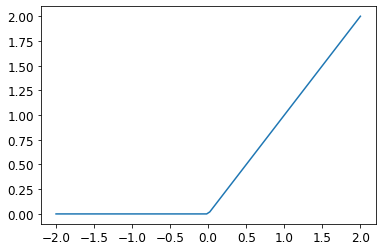

In [127]:
plot_function(F.relu)

In [128]:
simple_net = nn.Sequential(
    nn.Linear(28*28, 30),
    nn.ReLU(),
    nn.Linear(30, 1)
)

In [129]:
learner = Learner(dataloaders, simple_net, opt_func=SGD, loss_func=mnist_loss, metrics=batch_accuracy)
learner.fit(40, lr=0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.339450,0.416012,0.504416,00:00
1,0.156050,0.243690,0.792444,00:00
2,0.085183,0.119290,0.913641,00:00
3,0.055170,0.079665,0.939647,00:00
4,0.041383,0.061986,0.954367,00:00
5,0.034415,0.052091,0.964181,00:00
6,0.030449,0.045856,0.965653,00:00
7,0.027891,0.041601,0.966634,00:00
8,0.026058,0.038509,0.968106,00:00
9,0.024645,0.036147,0.968106,00:00


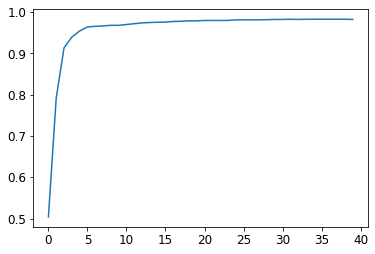

In [130]:
plt.plot(L(learner.recorder.values).itemgot(2))

In [131]:
# recorder.values is a list of tuples: (train_loss, validation_loss, batch_accuracy)
learner.recorder.values[-1]

(#3) [0.014215338975191116,0.020526675507426262,0.98233562707901]

### Training using FastAI's Library

In [132]:
dataloaders = ImageDataLoaders.from_folder(path)
learner = cnn_learner(dataloaders, resnet18, pretrained=True, loss_func=F.cross_entropy, metrics=accuracy)
learner.fine_tune(3, 1e-2)

/opt/conda/envs/fastai/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch,train_loss,valid_loss,accuracy,time
0,0.197134,0.121204,0.964671,00:06


epoch,train_loss,valid_loss,accuracy,time
0,0.045037,0.030069,0.994603,00:08
1,0.016425,0.012880,0.996565,00:08
2,0.006049,0.007634,0.997547,00:08


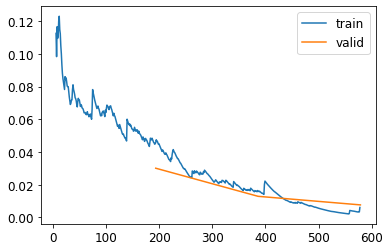

In [133]:
learner.recorder.plot_loss()

In [134]:
# how many training samples and batches do we have?
count = 0
batches = 0
for xb, yb in dataloaders.train:
    count += xb.shape[0]
    batches += 1
print(count, batches)

12352 193


In [135]:
xb, yb = dataloaders.train.one_batch()
xb.shape, yb.shape
xb.device, yb.device

(device(type='cuda', index=0), device(type='cuda', index=0))

### Visualizing the Model's Architecture

In [136]:
!pip install hiddenlayer

You should consider upgrading via the '/opt/conda/envs/fastai/bin/python3.8 -m pip install --upgrade pip' command.


/opt/conda/envs/fastai/lib/python3.8/site-packages/torch/onnx/symbolic_helper.py:712: UserWarning: ONNX export mode is set to inference mode, but operator batch_norm is set to inference mode. The model will be exported in inference, as specified by the export mode.
  warnings.warn("ONNX export mode is set to " + training_mode +
/opt/conda/envs/fastai/lib/python3.8/site-packages/torch/onnx/symbolic_helper.py:712: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to inference mode. The model will be exported in inference, as specified by the export mode.
  warnings.warn("ONNX export mode is set to " + training_mode +


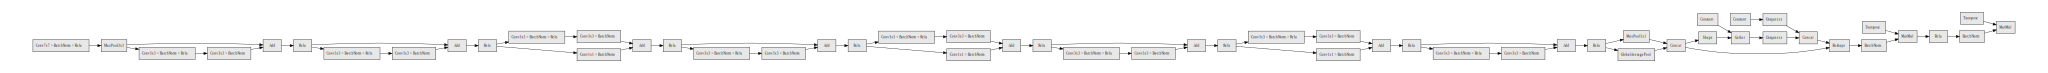

In [137]:
import hiddenlayer as hl

transforms = [
    # Fold Conv, BN, RELU layers into one
    hl.transforms.Fold("Conv > BatchNorm > Relu", "ConvBnRelu"),
    # Fold Conv, BN layers together
    hl.transforms.Fold("Conv > BatchNorm", "ConvBn"),
    # Fold bottleneck blocks
    hl.transforms.Fold("""
        ((ConvBnRelu > ConvBnRelu > ConvBn) | ConvBn) > Add > Relu
        """, "BottleneckBlock", "Bottleneck Block"),
    # Fold residual blocks
    hl.transforms.Fold("""ConvBnRelu > ConvBnRelu > ConvBn > Add > Relu""",
                       "ResBlock", "Residual Block"),
    # Fold repeated blocks
    hl.transforms.FoldDuplicates(),
]

graph = hl.build_graph(learner.model, xb, transforms=transforms)
graph

# Questions

**1. How is a greyscale image represented on a computer? How about a color image?**

Grayscale images are represented as matrices of integers (the pixels) in the range 0-255. Color images are similarly represented, but we use 3 such matrices, one for each color (red, green and blue) from whose combinations all other colors are derived.

**2. How are the files and folders in the MNIST_SAMPLE dataset structured? Why?**

They're organized in two subfolders: `train` and `test`. The former contains the training set, and the latter the test or validation set.

**3. Explain how the "pixel similarity" approach to classifying digits works.**

It's a baseline model than simply generates a reference image for each digit by averaging the values in all of the corresponding training images. Once we have that average image we can compare on seeing images against it and measure the pixel distance. The distance can be either an L1 or L2 norm or any other distance function we want.

**4. What is a list comprehension?**

It's just special syntactic sugar that Python provides for common loop constructs that involves creating new lists and adding elements conditionally.

**5. What is a rank-3 tensor?**

It's a three dimensional array of numbers.

**6. What is the difference between tensor rank and shape? How do you get the rank from the shape?**

The rank is just a number that tells you how many dimensions of tensor has. The shape of a tensor tells you how many elements there are in each dimension.

**7. What are RMSE and L1 norm?**

RMSE represents a weighted average difference between predicted values and expected values with strong penalties on large deviations.

L1 represents the sum of distance between predicted and expected values.

**8. How can you apply a calculation on thousands of numbers at once, many thousands of times faster than a Python loop?**

By using vectorized operations available in `numpy` or `torch`. The latter is able to efficiently execute them in GPUs.

**9. Create a 3x3 tensor or array containing the numbers from 1 to 9. Double it. Select the bottom right four numbers.**

In [138]:
t = tensor([[1, 2, 3],
            [4, 5, 6],
            [7, 8, 9]])
t *= 2
t[1:,1:]

tensor([[10, 12],
        [16, 18]])

**10. What is broadcasting?**

It's a way to perform operations between tensors of different shape which share one or more dimensions. For example, a vector of N elements and a matrix of NxM elements, or  a matrix of NxM elements and a tensor of shape MxNxP). It saves users from having to explicitly create matching tensors, and it does it in an efficient manner by creating just a virtual tensor with virtual copies of the original smaller tensor.

**11. Are metrics generally calculated using the tree set or the validation set? Why?**

Both, although the most useful information comes from the validation or test set since it is a proxy for the expected performance of the model in production. Checking the metrics for the training set can be useful for debugging purposes.

**12. What is SGD?**

Stochastic Gradient Descent. An optimization technique that uses a random subset of the data to find the gradients that inform how to change parameters to minimize the cost function.

**13. Why does SGD use mini-batches?**

For efficiency but also to improve generalization error. The latter is achieved by training to avoid plateauing in local minima that could be the product of noise in any given batch.

**14. For the seven steps in SGD for machine learning?**

   1. Initialize weights
   2. Compute predictions
   3. Compute loss 
   4. Compute gradients
   5. Test for convergence
   6. Update parameters using gradients 
   7. Repeat starting from step B.

**15. How do I initialize the weights in a model?**

Random initialization is a good idea, although researchers have found other somewhat more sophisticated methods.

**16. What is loss?**

It's a scalar-valued function that represents how good or bad are our model's predictions. It must be differentiable with respect to the weights

**17. Why can't we use always a high learning rate?**

Because we could overshoot and cause never-ending oscillations. In other cases, SGD may still converge but it will do so much more slowly due to unnecessary back-and-forth in both sides of a convex region.

**18. What is a gradient?**

It's a vector that represents how to move in parameters space in order to decrease most rapidly the value of the loss function.

**19. Do you need to know how to calculate gradients yourself?**

Not really unless you're building neural net completely from scratch. If you're using a framework like PyTorch, gradients are automatically computed for you.

**20. Why can't use accuracy as a loss function?**

Because it's not smooth and differentiable like the loss function. Small changes in paramete space will most likely not make any difference in classification, so the algorithm will get stuck very early on. A loss function usually encodes not just classification accuracy but also confidence on the classification. That allows to move smoothly in parameter space even when the classification accuracy doesn't change from one iteration to another.

**21. Draw the sigmoid function. What is special about its shape?**

It has a linear region in the middle and two nonlinear regions for sufficiently large or small values.

**22. What is the difference between a loss function and a metric?**

A metric is an error measure designed for humans to understand and discuss. A loss is a proxy of the metric function that must be differentiable (so it can be used with the backpropagation algorithm) and capture both the accuracy and confidence that a model has in its predictions.


**23. What is the function to calculate new weights using a learning rate?**

The gradient of the loss function (plugged into the update parameters equation)

**24. What does the `DataLoader` class do?**

It can load data from a source (e.g., file system), separate it into training and test subsets, and provide it in appropriately sized and shuffled batches.

**25. Write pseudocode showing the basic steps taken in each epoch for SGD.**

```python
for _ in epochs:
    predictions = compute_predictions(model, inputs)
    loss = compute_loss(predictions, targets)
    
    all_metrics.append(compute_metrics(predictions, targets))
    losses.append(loss)

    gradient = compute_gradient(loss)
    update_parameters(model.parameters, gradient)
```

**26. Create a function that, if passed two arguments `[1, 2, 3, 4]` and `"abcd"`, returns `[(1, 'a'), (2, 'b'), (3, 'c'), (4, 'd')]`. What is special about that output data structure?**

```python
def bind(inputs, targets):
    return list(zip(inputs, targets))
```

There is nothing special about it, except that PyTorch expects that format for training data.

**27. What does `view` do in PyTorch?**

It reshapes a tensor to some other shape, but only in a virtual way (i.e., it doesn't really change the layout in memory nor does it allocate new memory.)

**28. What are the bias parameters in a neural network? Why do we need them?**

They provide an additional degree of freedom in each perceptron in the NN, preventing it from being anchored to the origin. Without it, the NN couldn't really approximate a lot of functions.

**29. What does the operator `@` do in Python?**

In the case of matrices, it performs matrix multiplication.

**30. What does the `backward` method do?**

It computes gradients for all variables involved in a computational graph (as long as the variables are marked as requiring gradients)

**31. Why do we have to zero the gradients?**

Because by default Pytorch keeps accumulating gradients in each variable involved in a computational graph.

**32. What information do we have to pass to `Learner`?**

+ The data loader
+ The model's architecture
+ The optimizer
+ The loss function
+ Any metrics to monitor during training and validation

**33. Show Python or pseudocode for the basic steps of a training loop**

```python
def train(model, epochs, data_loaders, loss_fn, optimizer=SGD, metrics=accuracy):
    for epoch in range(epochs):
        train_epoch(model, data_loaders.training, loss_fn, optimizer)
        report_metrics(model, data_loaders.validation, loss_fn, metrics)

def train_epoch(model, training_set, loss_fn, optimizer):
    for inputs, targets in training_set:
        predictions = model(inputs)
        loss = loss_fn(predictions, targets)
        optimizer.step(compute_gradients(loss))
        
def report_metrics(model, validation_set, loss_fn, metrics):
    for inputs, targets in validation_set:
        predictions = model(inputs)
        loss = loss_fn(predictions, targets)
        metrics_results = [metric(predictions, targets) for metric in metrics]
        report_results(loss, metrics_results)
```

**34. What is ReLU?**

It stands for Rectified Linear Unit, a fancy name for the expression `max(x, 0)`

**35. What is an activation function?**

A nonlinear function that is applied pointwise to tensors (typically after one or more linear transformations)

**36. What is the difference between `F.relu` and `nn.ReLU`?**

They're conceptually the same. The latter is needed when building models using `torch.nn.Sequential`, since it expects class instances.

**37. The universal approximation theorem shows that any function can be approximated as closely as needed using just one nonlinearity. So why do we normally use more?**

For efficiency. Models with more layers can use less units per layer and end up with the same accuracy as a model with a single very wide layer (one with an exponential number of units)